# Using Natural Language to Predict Programming Languange 
## Webscraping and Natural Language Processing Project 
### Presented by Chris Everts, Randy French, and Malachi Hale

## Executive Summary 

### Project Goal

For this project, we will be scraping data from GitHub repository README files. The goal will be to build a model that can predict what programming language a repository is, given the text of the README file.

### Outline 

We take the following steps: 

 - **Acquire** the text data from GitHub READme files utilizing the GitHub API. 
 - **Prepare** the data:
 
     - *First* by dropping unneeded information in the data set:
     
         - eliminating all image formatting text inside of angle brackets, 
         - eliminating all URL links from the text data, 
         - dropping rows with null values, 
         - eliminating rows with text in non-Roman characters, and
         - selecting only the eliminates whose language is within the top four most common languages.
         
     - *Second* we clean the remaining data by:
          - Performing a basic "data cleaning" through converting all text to lower case, normalize unicode strings, encoding/removing ASCII, and eliminating all foreign characters. 
          - Tokenizing the text data. 
          - Creating additional columns of stemmed data and lemmatized data. 
     
 - **Explore** the text data by addressing the following questions: 
    - What are the most common words in READme files?
    - Does the length of the READme file vary by programming language?
    - Do different programming languages use a different number of unique words?
    - What does the distribution of IDFs look like for the most common words?
    
 - **Model** the data to classify based on programming language based on the READme file text.
     - We use the classification models Naive Bayes, SVC, Decision Tree, Random Forest, K Nearest Neighbors, and Logistic Regression. 
     - We run each of these models on the stemmed data, the lemmatized data, and the cleaned data. 
     - Based on the accuracy score on the validate dataset, we choose the best model to run on the test dataset.
     
### Key Findings

We will demonstrate that we can use the Random Forest  model on the lemmatized text data to predict with an accuracy greater than baseline the programming language that corresponds to each READme file. 

### Recommendation 

We were able to create a successful model that predicted better than baseline which programming language a READme file was likely to accompany. There are, however, some ways that we may be able to fortify our model.

In this project, we began with an initial dataset of 200 READme files. To make our model even more robust in the future, we may explore using a larger sample of READme files. 

Furthermore, because natural language differs so signficantly by geographic location, it may be useful to build separate classification models based on the repository creator's location. 

## Import Libraries

In [1]:
#Pandas
import pandas as pd

#Imports for web scraping and text formatting
import re
import requests
from bs4 import BeautifulSoup
import unicodedata
import json

#Stats 
from scipy import stats 

#Numpy
import numpy as np

#Import repository files
import explore 
import prepare  
import acquire  
import model as m

#Merge
from mergedeep import merge

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# imports for modeling
from sklearn.model_selection import train_test_split

#Sparse Matrix Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

# imports for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm # for colormap tools
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import seaborn as sns


plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')

## Acquire

We will utilize the GitHub API to scrape and extract the text of READme files for each page, as well as the primary language of the repository. Please see the `acquire.py` file in this repository for more information on our acquire process.

In [2]:
#Use the scrape github function from the acquire module to acquire the dataframe containing the names of the
#repositories and the contents of the readme files
df = acquire.scrape_github_data()

#convert the data into a dataframe
df = pd.DataFrame(df)
df.head()

,repo,language,readme_contents
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,# E-commerce-Customer-service-robot\n电商多轮对话客服机...
1,Azure/fta-customerfacingapps,C#,# FastTrack for Azure\n\nSee our [FastTrack fo...
2,ELMAHDI-AR/CustomerAuthentication-With-ASP.NET...,PowerShell,
3,kpei/Customer-Analytics,Jupyter Notebook,# Customer Analytics iPython Notebook\nSee htt...
4,Sylius/CustomerOrderCancellationPlugin,PHP,> :warning: **BEWARE!**\n> This repository has...


In [3]:
# read in the json file generated by compiling the acquire.py file
df = pd.read_json('data2.json')

In [4]:
len(df)

200

In [5]:
df.head()

,repo,language,readme_contents
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,# E-commerce-Customer-service-robot\n电商多轮对话客服机...
1,Azure/fta-customerfacingapps,C#,# FastTrack for Azure\n\nSee our [FastTrack fo...
2,ELMAHDI-AR/CustomerAuthentication-With-ASP.NET...,PowerShell,
3,kpei/Customer-Analytics,Jupyter Notebook,# Customer Analytics iPython Notebook\nSee htt...
4,Sylius/CustomerOrderCancellationPlugin,PHP,> :warning: **BEWARE!**\n> This repository has...


### Key Takeaways
 - We access the GitHub API to obtain a DataFrame of 200 rows that contains:
     - the name of the repository, 
     - the programming language used, 
     - the contents of the repository's READme file. 
 - We saved the results of our webscraping to the file `data2.json`.

## Prepare

To prepare our data, we will perform two tasks. First, we will drop unneeded rows in our dataset. Second, we will clean the text, as well as create columns for stemmed and lemmatized text data. For more information about our data preparation process, please see the `prepare.py` file in this repository. 

In [6]:
# do drop unneeded data first then prep
df = prepare.drop_unneeded_data(df)

In [7]:
len(df)

136

We have eliminated 64 rows from our dataset. Now we are ready to clean, stem, and lemmatize the text data.

In [8]:
df = prepare.prepare_nlp_data(df, content = 'readme_contents')

In [9]:
df.head()

,repo,language,readme_contents,clean,stemmed,lemmatized
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,EcommerceCustomerservicerobot SeqSeqGRUGRU...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...
1,kpei/Customer-Analytics,Jupyter Notebook,Customer Analytics iPython Notebook See,customer analytics ipython notebook see,custom analyt ipython notebook see,customer analytics ipython notebook see
2,Sylius/CustomerOrderCancellationPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...
3,optiflow/rfm-customer-segmentation,Jupyter Notebook,Recency Frequency and Monetary RFM Customer S...,recency frequency monetary rfm customer segmen...,recenc frequenc monetari rfm custom segment us...,recency frequency monetary rfm customer segmen...
4,Sylius/CustomerReorderPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...


### Key Takeaways
 - Using our `drop_unneeded_data` function, we:
     - eliminated all image formatting text, 
     - eliminated all URL text data, 
     - dropped rows with null values, 
     - eliminated rows with foreign script text in the READme file, 
     - dropped all rows with a programming language not in the top four most common programming languages, and
     - reset of the new DataFrame. 
 - Using our `prepare_nlp_data` function:
     - We created a new column with `clean` data. For the text data in this column, we:
         - converted all characters to lowercase, 
         - normalized all unicode data, encoded the data, and removed ASCII, 
         - tokenized the strings, and
         - removed stopwords from the text data. 
     - We used our new `clean` column to create the columns: 
         - `stemmed` with stemmed text data and 
         - `lemmatized` with lemmatized text data. 

## Explore

In this section, we will address the following questions: 
 - What are the most common words in READme files?
 - Does the length of the READme vary by programming language?
 - Do different programming languages use a different number of unique words?
 - What does the distribution of IDFs look like for the most common words?

### What are the most common words in READme files?

We will create a single string of our text data so that we can determine what the most frequently used words in this string are. 

In [10]:
words = ' '.join(df.stemmed)

In [11]:
words[0:1500]

'ecommercecustomerservicerobot seqseqgrugruteach forc torch jieba numpi custom analyt ipython notebook see warn bewar repositori deprec maintain evolv syliu team still use compat syliu version risk bug fix custom order cancel plugin plugin allow custom cancel place order process screenshot show custom order page cancel buttonsdocsscreenshot png busi valu far custom chang mind alreadi place order administr cancel order howev ask question cant custom cancel order yet paid come custom order cancel plugin allow cancel unpaid order straight order histori view instal bewar instal instruct assum your use symfoni flex dont take look legaci instal instructiondocslegacyinstal md howev strongli encourag use symfoni flex much quicker instal plugin requir compos bash compos requir syliuscustomerordercancellationplugin rememb allow commun recip compos config extra symfoni allowcontrib true plugin instal process extens point custom order cancel plugin use order entiti deriv syliuscorebundl well alrea

In [12]:
frequencies = pd.Series(words.split()).value_counts()

In [13]:
frequencies.head(20)

custom      923
data        424
use         407
model       258
creat       209
instal      169
project     151
run         150
file        150
featur      147
new         144
notebook    136
account     133
magento     128
set         127
segment     115
png         110
valu        107
code        106
churn       106
dtype: int64

In [14]:
top_20_words = frequencies.head(20)

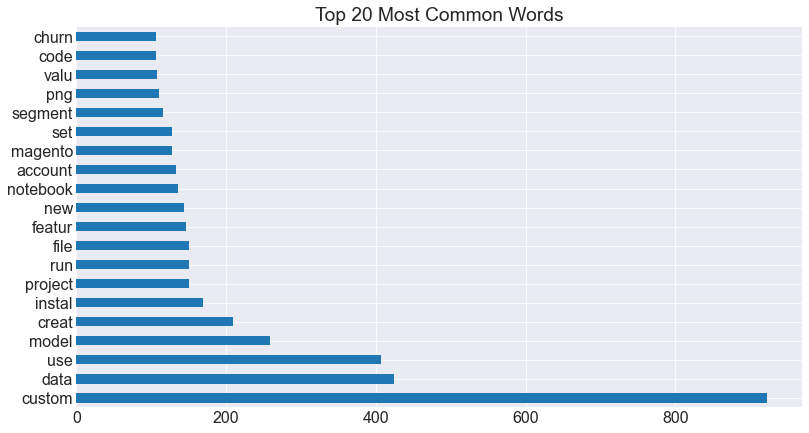

In [15]:
#Graph Most Common Words
top_20_words.plot.barh()
title = plt.title('Top 20 Most Common Words')

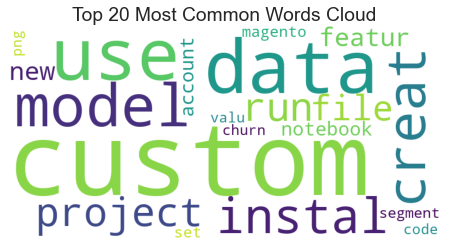

In [16]:
data = {k: v for k, v in top_20_words.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title("Top 20 Most Common Words Cloud")
plt.show()

We can also address this question by looking at the most common words per programming language.

First we split the data into train, validate, and test.

In [17]:
train, validate, test = prepare.split_data(df)

train---> (75, 6)
validate---> (33, 6)
test---> (28, 6)


In [18]:
#Get words counts for all languages
all_word_counts = explore.get_word_counts_series(train, 'lemmatized')
#Python Word Counts
python_word_counts = explore.get_word_counts_series(train[train.language == 'Python'], 'lemmatized')
#JavaScript Word Counts
javascript_word_counts = explore.get_word_counts_series(train[train.language == 'JavaScript'], 'lemmatized')
#PHP word counts
php_word_counts = explore.get_word_counts_series(train[train.language == 'PHP'], 'lemmatized')
#Jupyter Word Counts
jupyter_word_counts = explore.get_word_counts_series(train[train.language == 'Jupyter Notebook'], 'lemmatized')

In [19]:
#list of all word counts
word_counts_list = [python_word_counts, javascript_word_counts, php_word_counts, jupyter_word_counts, all_word_counts]
#create column names
column_names = list(df.language.unique())
column_names.append('all')

#Get languages
languages = list(df.language.unique())

In [20]:
#Create word counts DataFrame
word_counts = pd.concat(word_counts_list, axis=1).fillna(0).astype(int)
#Set column names
word_counts.columns = column_names
word_counts.head()

,Jupyter Notebook,PHP,Python,JavaScript,all
customer,55,44,197,180,476
data,29,6,7,227,269
py,28,0,0,3,31
transaction,18,0,0,9,27
alexa,17,0,0,0,17


<Figure size 1152x648 with 0 Axes>

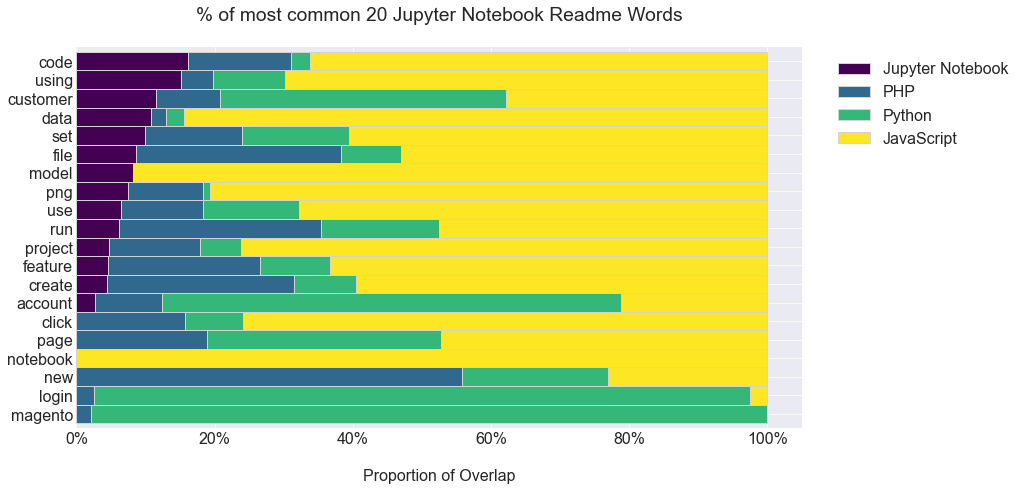

<Figure size 1152x648 with 0 Axes>

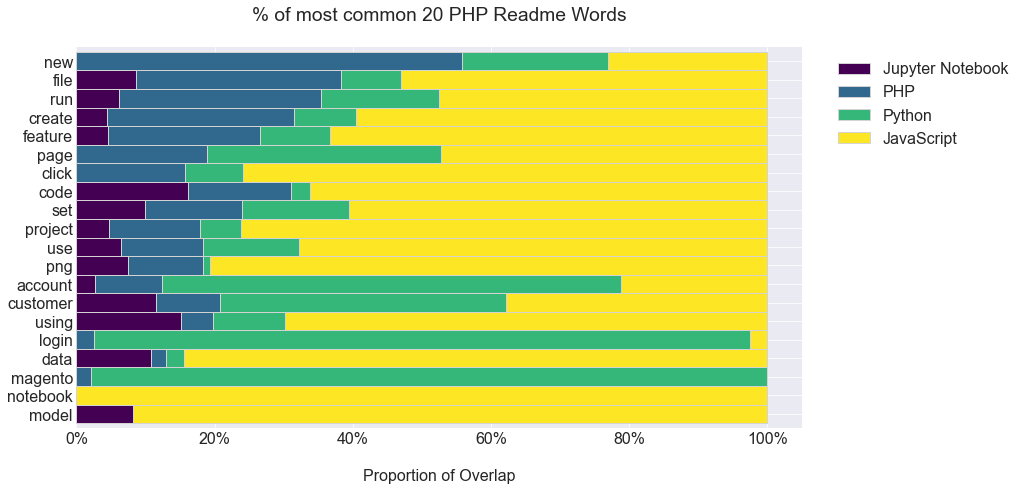

<Figure size 1152x648 with 0 Axes>

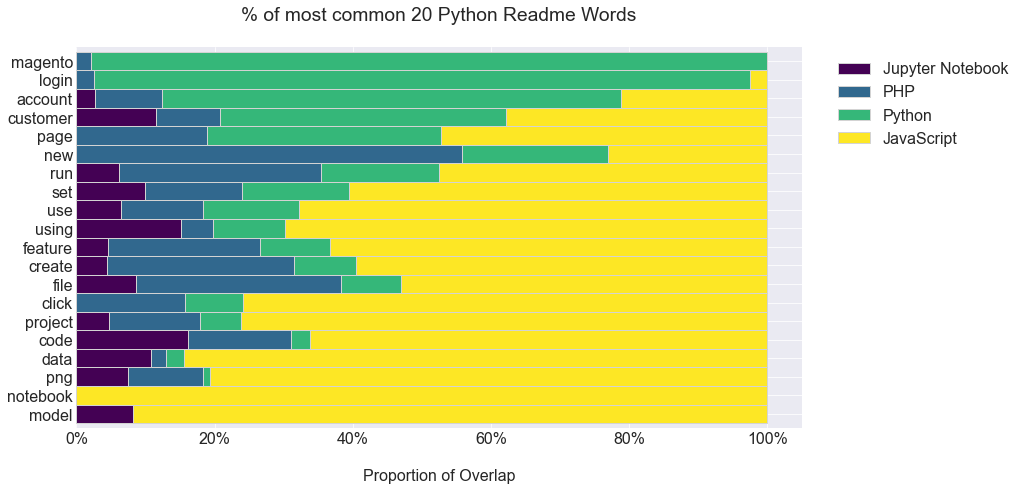

<Figure size 1152x648 with 0 Axes>

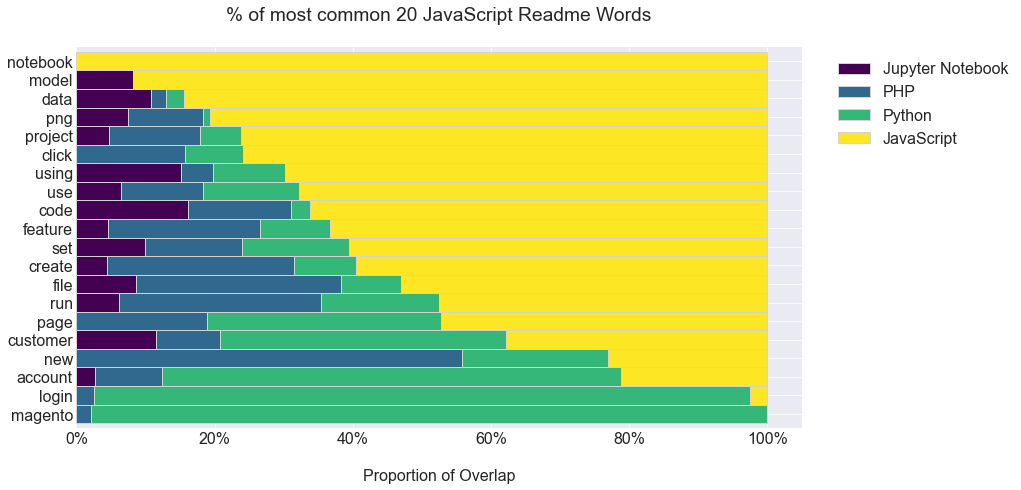

In [21]:
#Plot word coutns
for language in languages:
    explore.plot_overlap_stacked_bar(word_counts, language, cmap = 'viridis')

Now we will explore what the most common bigrams in the text data are. 

In [24]:
#Create DataFrames for each language
jupyter = df[df.language == "Jupyter Notebook"]
php = df[df.language == "PHP"]
python = df[df.language == "Python"]
java = df[df.language == "JavaScript"]

In [25]:
jupyter_words = ' '.join(jupyter.lemmatized)
php_words = ' '.join(php.lemmatized)
python_words = ' '.join(python.lemmatized)
java_words = ' '.join(java.lemmatized)

In [26]:
words_languages = [jupyter_words, php_words, python_words, java_words]
language_names = ["Jupyter", "PHP", "Python", "Java"]

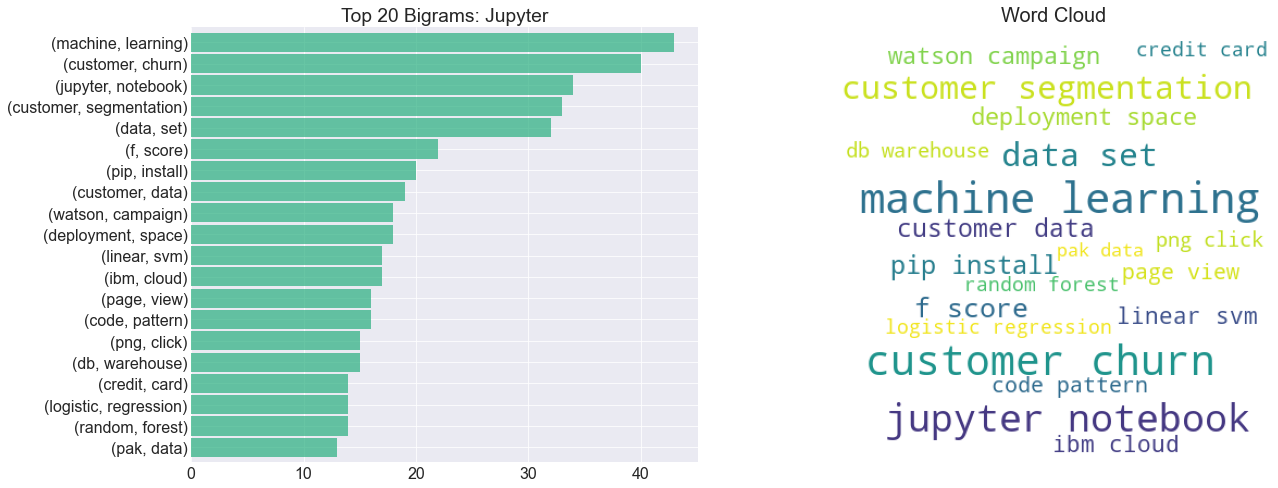

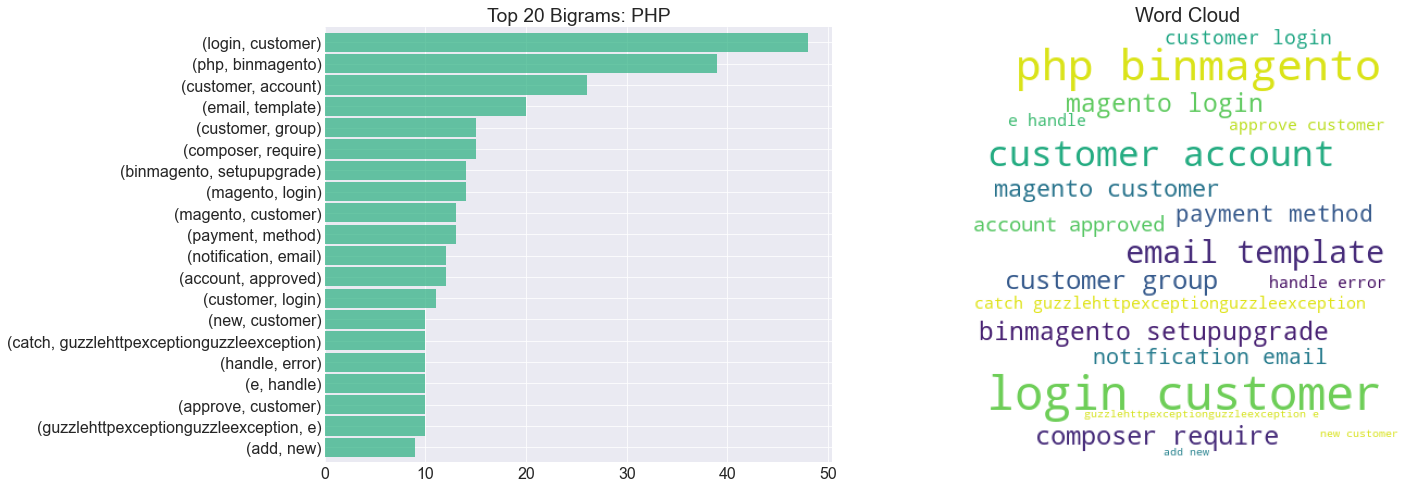

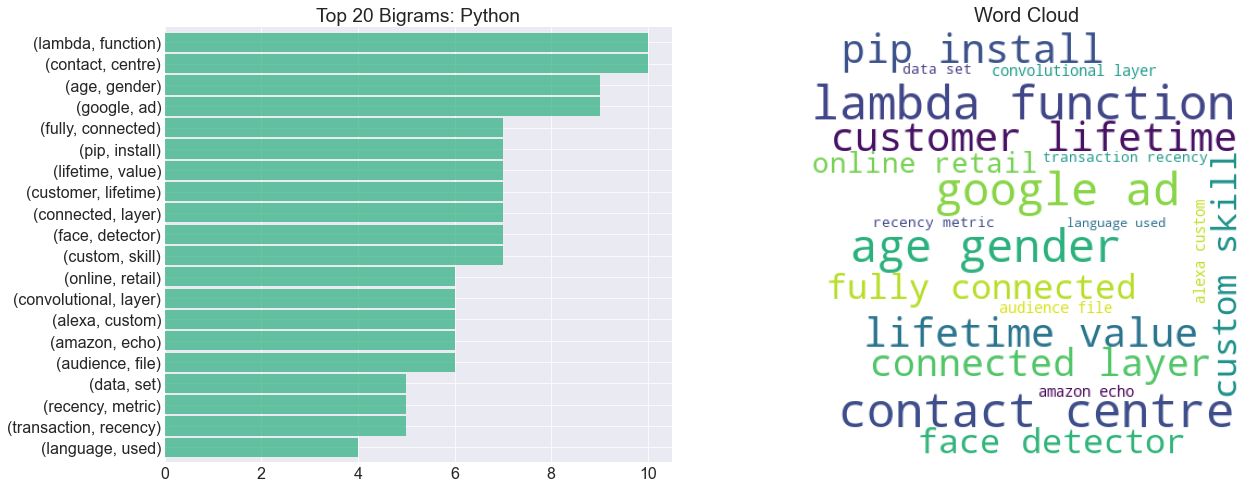

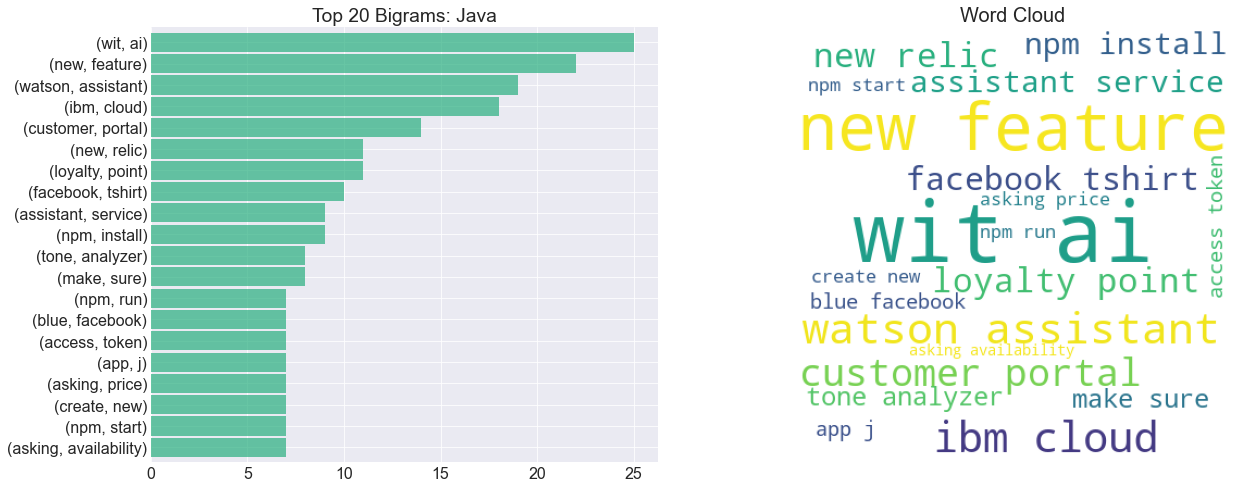

In [27]:
for lang, name in zip(words_languages, language_names):
    explore.bigram_count_word_cloud(lang.split(), title_name = name)

We can also look at the most common trigrams. 

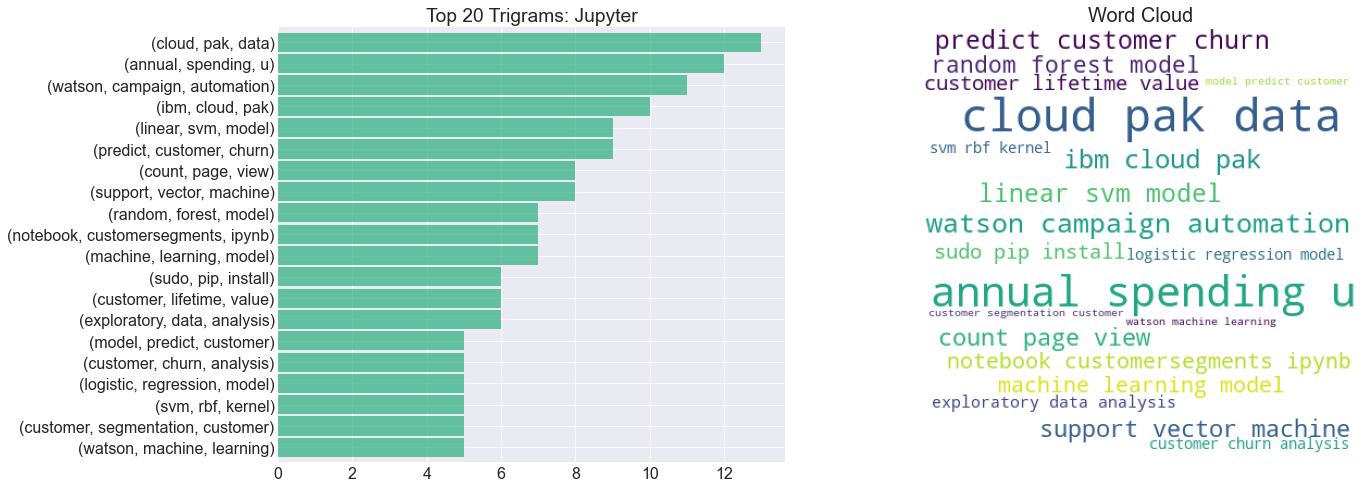

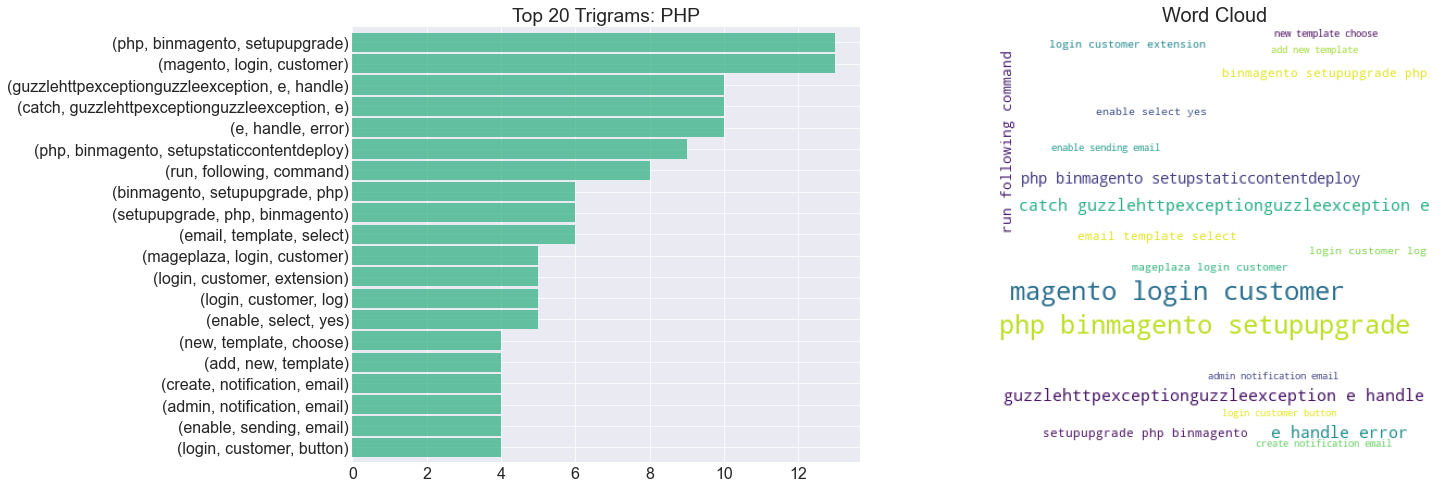

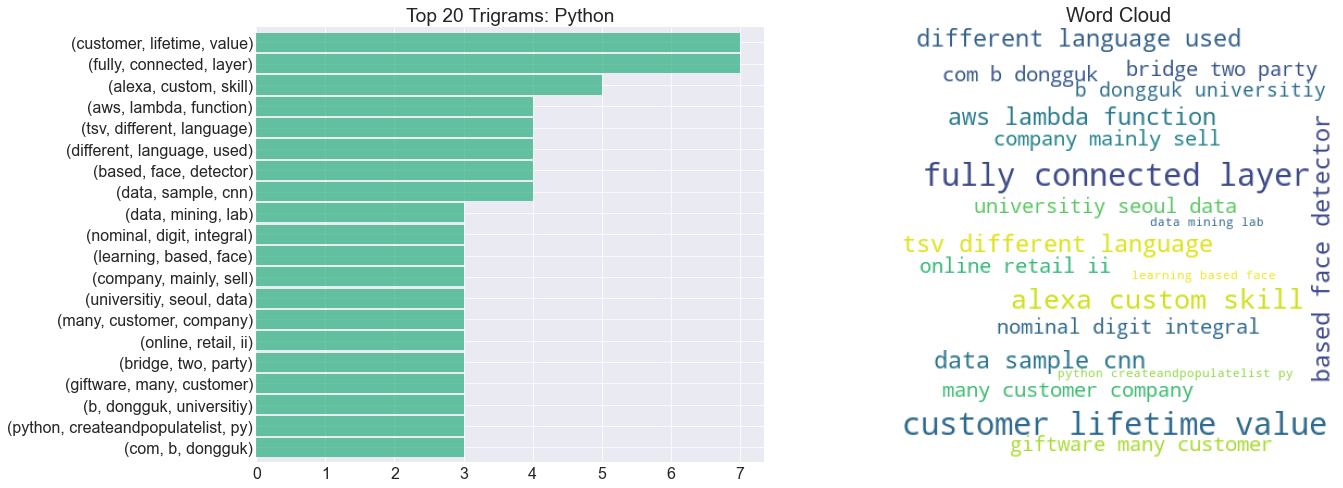

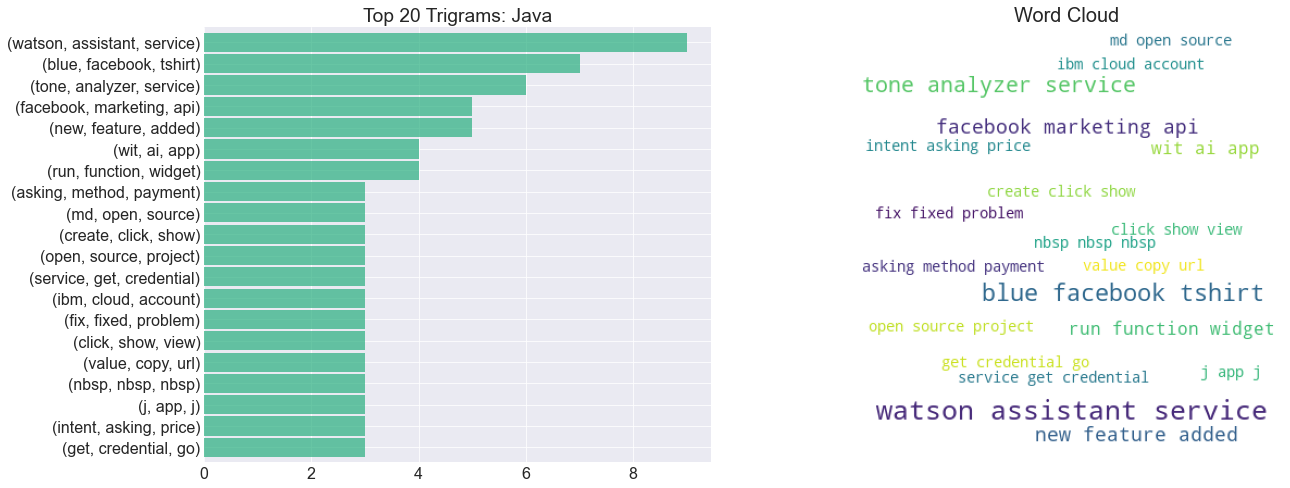

In [28]:
for lang, name in zip(words_languages, language_names):
    explore.trigram_count_word_cloud(lang.split(), title_name = name)

### Does the length of the READme files differ by programming language?

To answer this question, we will create a new column in the DataFrame for the length of each file. To create this column, we first create a list of each READme file's length.

In [29]:
#Create empty list
length_readme = []
#Loop through the DataFrame READme files
for i in range(len(df)):
    length_readme.append(len(df.readme_contents[i]))

In [30]:
#Convert list of READme lengths into DataFrame
length_readme_df = pd.DataFrame(length_readme)

In [31]:
#Merge main DataFrame and READme length DataFrame
df_with_length = pd.concat([df, length_readme_df], axis = 1)

In [32]:
df_with_length.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,0
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,EcommerceCustomerservicerobot SeqSeqGRUGRU...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,83
1,kpei/Customer-Analytics,Jupyter Notebook,Customer Analytics iPython Notebook See,customer analytics ipython notebook see,custom analyt ipython notebook see,customer analytics ipython notebook see,40
2,Sylius/CustomerOrderCancellationPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,1901
3,optiflow/rfm-customer-segmentation,Jupyter Notebook,Recency Frequency and Monetary RFM Customer S...,recency frequency monetary rfm customer segmen...,recenc frequenc monetari rfm custom segment us...,recency frequency monetary rfm customer segmen...,255
4,Sylius/CustomerReorderPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,2764


In [33]:
#Rename length column 
df_with_length.rename(columns = {0: "length"}, inplace = True)

In [34]:
df_with_length.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,length
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,EcommerceCustomerservicerobot SeqSeqGRUGRU...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,83
1,kpei/Customer-Analytics,Jupyter Notebook,Customer Analytics iPython Notebook See,customer analytics ipython notebook see,custom analyt ipython notebook see,customer analytics ipython notebook see,40
2,Sylius/CustomerOrderCancellationPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,1901
3,optiflow/rfm-customer-segmentation,Jupyter Notebook,Recency Frequency and Monetary RFM Customer S...,recency frequency monetary rfm customer segmen...,recenc frequenc monetari rfm custom segment us...,recency frequency monetary rfm customer segmen...,255
4,Sylius/CustomerReorderPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,2764


In [35]:
#Get list of unique langauges
df_with_length.language.value_counts()

Jupyter Notebook    49
PHP                 38
Python              25
JavaScript          24
Name: language, dtype: int64

In [36]:
#Create DataFrames for each language
jupyter = df_with_length[df_with_length.language == "Jupyter Notebook"]
php = df_with_length[df_with_length.language == "PHP"]
python = df_with_length[df_with_length.language == "Python"]
java = df_with_length[df_with_length.language == "JavaScript"]

In [37]:
#Reset the index of the new DataFrames 
jupyter = jupyter.reset_index()
php = php.reset_index()
python = python.reset_index()
java = java.reset_index()

In [38]:
#Calculate median and average lengths for each DataFrame
dataframes = [jupyter, php, python, java]
for lang in dataframes:
    print(lang.language[0])
    print("Median READme length", lang.length.median())
    print("Mean READme length", lang.length.mean())
    print(" ")

Jupyter Notebook
Median READme length 1644.0
Mean READme length 3242.938775510204
 
PHP
Median READme length 746.5
Mean READme length 1439.4736842105262
 
Python
Median READme length 644.0
Mean READme length 1579.96
 
JavaScript
Median READme length 1107.5
Mean READme length 2354.375
 


Now we will run statistical testing to determine if the average length of the READme file for each language is significantly different than the length of the READme file for other languages.

As is customary, for the following statistical tests, our alpha value will be 0.05.

In [39]:
not_jupyter = [php, python, java]
for lang in not_jupyter:
    print(lang.language[0], "average READme length vs Jupyter average length")
    print(stats.ttest_ind(lang.length, jupyter.length))
    print(" ")

PHP average READme length vs Jupyter average length
Ttest_indResult(statistic=-1.8616184902205477, pvalue=0.06611305850967955)
 
Python average READme length vs Jupyter average length
Ttest_indResult(statistic=-1.3835831902700682, pvalue=0.17076087452026897)
 
JavaScript average READme length vs Jupyter average length
Ttest_indResult(statistic=-0.7091768908777644, pvalue=0.4805370466090102)
 


In [40]:
not_php = [python, java]
for lang in not_php:
    print(lang.language[0], "average READme length vs PHP average length")
    print(stats.ttest_ind(lang.length, php.length))
    print(" ")

Python average READme length vs PHP average length
Ttest_indResult(statistic=0.22927542200610088, pvalue=0.8194218622696456)
 
JavaScript average READme length vs PHP average length
Ttest_indResult(statistic=1.3276887891704021, pvalue=0.18931025885020386)
 


In [41]:
print("Python average READme length vs Java average length")
print(stats.ttest_ind(python.length, java.length))

Python average READme length vs Java average length
Ttest_indResult(statistic=-0.8921389809818724, pvalue=0.3768633998634675)


The above statistical tests indicate that none of the lengths of the READme files of one programming language differ signficantly from the lengths of the READme files of any other programming language. 

We can also run statistical testing comparing the length of each programming language's READme files to the overall population READme file length.

In [42]:
for lang in dataframes:
    print(lang.language[0], "READme length vs all languages READme lengths")
    print(stats.ttest_1samp(lang.length, df_with_length.length.mean()))
    print(" ")

Jupyter Notebook READme length vs all languages READme lengths
Ttest_1sampResult(statistic=1.193575271661778, pvalue=0.23851004226093867)
 
PHP READme length vs all languages READme lengths
Ttest_1sampResult(statistic=-2.4404955964402517, pvalue=0.019575195371731947)
 
Python READme length vs all languages READme lengths
Ttest_1sampResult(statistic=-1.271917776615204, pvalue=0.21558940036119228)
 
JavaScript READme length vs all languages READme lengths
Ttest_1sampResult(statistic=0.11482863002003657, pvalue=0.9095775400216792)
 


The T-Test here indicated that the length of the PHP READme files differs signficantly from the overall population READme file length.

### Do different programming languages use a different number of unique words?

To answer this question, we can first simply check how many unique words are used in each language.

In [43]:
#Get number of unique words in Jupyter Notebook READme files
jupyter_words = ' '.join(jupyter.stemmed)
jupyter_unique_words = len(set(re.findall('\w+', jupyter_words)))
jupyter_unique_words

2630

In [44]:
#Get number of unique words for PHP READme files
php_words = ' '.join(php.stemmed)
php_unique_words = len(set(re.findall('\w+', php_words)))
php_unique_words

1106

In [45]:
#Get number of unique words for Python READme files
python_words = ' '.join(python.stemmed)
python_unique_words = len(set(re.findall('\w+', python_words)))
python_unique_words

1291

In [46]:
#Get number of unique words for Java READme files
java_words = ' '.join(java.stemmed)
java_unique_words = len(set(re.findall('\w+', java_words)))
java_unique_words

1395

Yes, each languages does use a different number of unique words. To test the stastical significance of the difference of the amount of unique words per READme file per language, however, we will need to add a `unique_words` column to our dataframe.

In [47]:
#Empty list
all_words_unique = []
#Append number of unique words per READme file to list
for i in range(len(df)):
    all_words_unique.append(len(set(re.findall('\w+', df.stemmed[i]))))

In [48]:
#Convert number of unique words list into a DataFrame
words_unique_df = pd.DataFrame(all_words_unique)

In [49]:
#Concatenate main DataFrame with unique words DataFrame
df_with_unique_words = pd.concat([df, words_unique_df], axis = 1)

In [50]:
df_with_unique_words.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,0
0,gongdelu/E-commerce-Customer-service-robot,Jupyter Notebook,EcommerceCustomerservicerobot SeqSeqGRUGRU...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,ecommercecustomerservicerobot seqseqgrugruteac...,6
1,kpei/Customer-Analytics,Jupyter Notebook,Customer Analytics iPython Notebook See,customer analytics ipython notebook see,custom analyt ipython notebook see,customer analytics ipython notebook see,5
2,Sylius/CustomerOrderCancellationPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,107
3,optiflow/rfm-customer-segmentation,Jupyter Notebook,Recency Frequency and Monetary RFM Customer S...,recency frequency monetary rfm customer segmen...,recenc frequenc monetari rfm custom segment us...,recency frequency monetary rfm customer segmen...,23
4,Sylius/CustomerReorderPlugin,PHP,warning BEWARE This repository has been depr...,warning beware repository deprecated maintaine...,warn bewar repositori deprec maintain evolv sy...,warning beware repository deprecated maintaine...,143


In [51]:
#Rename unique words column
df_with_unique_words.rename(columns = {0: "unique_words"}, inplace = True)

In [52]:
#Create DataFrames for each programming language
jupyter = df_with_unique_words[df_with_unique_words.language == "Jupyter Notebook"]
php = df_with_unique_words[df_with_unique_words.language == "PHP"]
python = df_with_unique_words[df_with_unique_words.language == "Python"]
java = df_with_unique_words[df_with_unique_words.language == "JavaScript"]

In [53]:
#Reset index of the new DataFrames
jupyter = jupyter.reset_index()
php = php.reset_index()
python = python.reset_index()
java = java.reset_index()

We will now run a T-test comparing the amount of unique words per READme file per programming language to the amount of unique words per READme file in other languages.

As usual, for the following stastical tests, we will set our alpha value equal to 0.05.

In [54]:
not_jupyter = [php, python, java]
for lang in not_jupyter:
    print(lang.language[0], "average unique words vs Jupyter average unique words")
    print(stats.ttest_ind(lang.unique_words, jupyter.unique_words))
    print(" ")

PHP average unique words vs Jupyter average unique words
Ttest_indResult(statistic=-2.433140313673896, pvalue=0.017064510499042333)
 
Python average unique words vs Jupyter average unique words
Ttest_indResult(statistic=-1.6128187626187684, pvalue=0.11115882462933681)
 
JavaScript average unique words vs Jupyter average unique words
Ttest_indResult(statistic=-0.7889065178819505, pvalue=0.43279310141216065)
 


In [55]:
not_php = [python, java]
for lang in not_php:
    print(lang.language[0], "average unique words vs PHP average unique words")
    print(stats.ttest_ind(lang.unique_words, php.unique_words))
    print(" ")

Python average unique words vs PHP average unique words
Ttest_indResult(statistic=0.4580777078010558, pvalue=0.6485243059897029)
 
JavaScript average unique words vs PHP average unique words
Ttest_indResult(statistic=1.8137204264009048, pvalue=0.07472229430094941)
 


In [56]:
print("Python average unique words vs Java average unique words")
print(stats.ttest_ind(python.unique_words, java.unique_words))

Python average unique words vs Java average unique words
Ttest_indResult(statistic=-0.9490050476017465, pvalue=0.34747246057657355)


Our testing indicated that PHP and Jupyter Notebook use a stastically significant different amount of unique words in their READme files.

We can also compare the amount of unique words of the READme files of each language to the overall population unique words.

In [57]:
dataframes = [jupyter, php, python, java]
for lang in dataframes:
    print(lang.language[0], "unique words vs all languages unique words")
    print(stats.ttest_1samp(lang.unique_words, df_with_unique_words.unique_words.mean()))
    print(" ")

Jupyter Notebook unique words vs all languages unique words
Ttest_1sampResult(statistic=1.4898071344052946, pvalue=0.14281701172334046)
 
PHP unique words vs all languages unique words
Ttest_1sampResult(statistic=-3.4211473401817645, pvalue=0.0015350607370688137)
 
Python unique words vs all languages unique words
Ttest_1sampResult(statistic=-1.1020450367274606, pvalue=0.28137148824009134)
 
JavaScript unique words vs all languages unique words
Ttest_1sampResult(statistic=0.25732548982471065, pvalue=0.799215716548088)
 


Only PHP uses a signficantly different amount of unique words in its READme files than the overall population.

### What does the distribution of IDFs look like for the most common words?

Recall that we calculated the top 20 most common words in the first question of this section.

In [58]:
top_20_words

custom      923
data        424
use         407
model       258
creat       209
instal      169
project     151
run         150
file        150
featur      147
new         144
notebook    136
account     133
magento     128
set         127
segment     115
png         110
valu        107
code        106
churn       106
dtype: int64

In [59]:
#Convert top 20 words into list 
top_20_list = top_20_words.index.to_list()

We need to calculate all our stemmed values to compare to our most frequent values.

In [60]:
values_stemmed = df.stemmed.to_dict()

We calculate the idf values using the following function. 

In [61]:
def idf(word):
    '''
    This function calculated the IDF value for each word in a document.
    '''
    n_occurences = sum([1 for doc in values_stemmed.values() if word in doc])
    return len(values_stemmed) / n_occurences

In [62]:
# put the unique words into a data frame
most_common_words_idf = (pd.DataFrame(dict(word=top_20_list))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False)
 .head(20))

In [63]:
most_common_words_idf

,idf
word,
png,8.000000
churn,7.555556
segment,6.181818
magento,5.913043
account,4.857143
notebook,4.857143
featur,4.121212
model,4.121212
new,3.487179


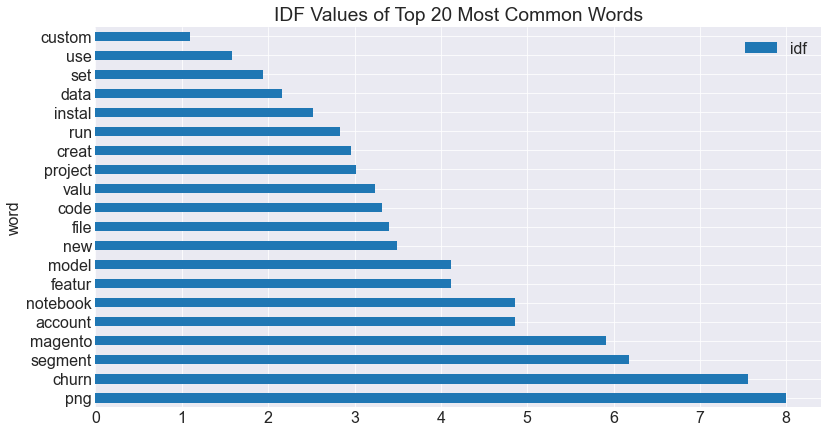

In [64]:
#Plot IDF of most common words
most_common_words_idf.plot.barh()
title = plt.title('IDF Values of Top 20 Most Common Words')

### Key Takeaways

In this Explore section, we addressed four questions: 
 - What are the most common words in READme files?
 
     - Overall, we found that words 'custom', 'data', 'use', and 'model' were the most frequently used words in all our READme files. 
     
     - The most frequently used words differ when we calculate word frequency separately by language. However, the words 'customer' and 'data' tended to appear frequently in the READme files for every language. 
     
     - Every language had a unique series of bigrams and trigrams that appeared most frequently in its corresponding READme files. 
     
     
 - Does the length of the READme file differ by programming language?
 
     - Using independent t-tests to compare the READme lengths of one language to another, we found:
     
         - None of the languages have on average significantly different mean READme lengths from one another.
         
     - Using a one-sample t-test to compare each language's READme length to the population mean, we found:
     
         -  PHP is the only language that differs significantly in the length of its READme files from the overall population.
    
    
 - Do different programming languages use a different number of unique words?
 
     - Using independent t-test to compare the amount of unique words in the READme files of different programming languages, we found:
     
         - Of all languages, only PHP and Jupyter Notebook differ significantly from each other in the amount of unique words used in READme files. 
         
     - Using a one-sample t-test to compare each language's READme unique words to the population mean, we found:
     
        - Only PHP differed signficantly from the overall population in its amount of unique words used. 
  
  
 - What does the distribution of IDFs look like for the most common words?
  
      - Using our top 20 most common words calculated in Question 1, we calculated the IDF values for each of our top 20 most common words. 
          - The words in the top 20 with the highest IDF value were "png", "churn", "segment", and "magneto".

## Modeling

We will use classification models on our cleaned, stemmed, and lemmatized text data. We will also look at how our data performs on bigrams versus single words. We will select the most accurate model to use on our test dataset.  

We will use the following DataFrame to store the results of our models.

In [179]:
# create dataframe to store the scores
score_df = pd.DataFrame(columns = ['model_name', 'train_score', 'validate_score'])

Before we begin modeling, we set a baseline accuracy.

### Set a Baseline

Before we begin using Classification models, we will set a baseline accuracy. Our baseline model will predict that every language is Jupyter Notebook.

In [180]:
#PHP is the baseline prediction
print(f'Baseline Accuracy: {round(max(train.language.value_counts()) / train.shape[0] *100)}%')

Baseline Accuracy: 36%


### Lemmatized

In [181]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

# split to X/y datasets 
X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [182]:
# create list of models to loop through
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), LogisticRegression()]

# create list of model names that correspond to models
model_names = ['Naive_Bayes_tfidf_lemmatized', 'SVC_tfidf_lemmatized', 'Decision_tree_tfidf_lemmatized', 
               'Random_forest_tfidf_lemmatized', 'KNN_tfidf_lemmatized', 'Log_reg_tfidf_lemmatized']

# initialize list of names of the languages
class_names = ['Jupyter Notebook', 'JavaScript', 'Python','PHP' ]

In [183]:
#Append results to score_df
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

### Stemmed

In [184]:
# bring in the vectorizer
tfidf = TfidfVectorizer()

X_data = tfidf.fit_transform(df.stemmed)
y_data = df.language

# split to X/y datasets 
X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [185]:
# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), LogisticRegression()]

# name the models
model_names = ['Naive_Bayes_stemmed', 'SVC_stemmed', 'Decision_tree_stemmed', 'Random_forest_stemmed', 'KNN_stemmed', 'Log_reg_stemmed']

In [186]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [187]:
score_df

,model_name,train_score,validate_score
0,Naive_Bayes_tfidf_lemmatized,0.880000,0.575758
1,SVC_tfidf_lemmatized,0.973333,0.787879
2,Decision_tree_tfidf_lemmatized,0.973333,0.727273
3,Random_forest_tfidf_lemmatized,0.973333,0.848485
4,KNN_tfidf_lemmatized,0.933333,0.727273
5,Log_reg_tfidf_lemmatized,0.946667,0.606061
6,Naive_Bayes_stemmed,0.826667,0.575758
7,SVC_stemmed,0.973333,0.757576
8,Decision_tree_stemmed,0.973333,0.696970
9,Random_forest_stemmed,0.973333,0.818182


### Cleaned 

In [188]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.clean)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [189]:
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(n_neighbors=10, weights= 'distance'),
             LogisticRegression()]

model_names = ['Naive_Bayes_tfidf_clean', 'SVC_tfidf_clean', 'Decision_tree_tfidf_clean', 'Random_forest_tfidf_clean', 'KNN_n10_tfidf_clean',
              'Log_reg_clean']

In [190]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

### Lemmatized Bigrams

In [191]:
tfidf = TfidfVectorizer(ngram_range=(2,2))
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [192]:
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier()]

model_names = ['Naive_Bayes_tfidf2', 'SVC_tfidf2', 'Decision_tree_tfidf2', 'Random_forest_tfidf2', 'KNN_bigrams_tfidf2']

In [193]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

### Evaluate Scores

We will print out a DataFrame of the results of our models, sorted by the accuracy on the validate dataset.

In [194]:
score_df.sort_values(by = 'validate_score', ascending = False)

,model_name,train_score,validate_score
3,Random_forest_tfidf_lemmatized,0.973333,0.848485
16,KNN_n10_tfidf_clean,0.973333,0.818182
9,Random_forest_stemmed,0.973333,0.818182
15,Random_forest_tfidf_clean,0.973333,0.818182
1,SVC_tfidf_lemmatized,0.973333,0.787879
13,SVC_tfidf_clean,0.973333,0.787879
7,SVC_stemmed,0.973333,0.757576
14,Decision_tree_tfidf_clean,0.973333,0.757576
2,Decision_tree_tfidf_lemmatized,0.973333,0.727273
4,KNN_tfidf_lemmatized,0.933333,0.727273


### Select Best Model 

The top score is the Random Forest Classsification method using the lemmatized dataset. Let's take a deeper look athe results from that model with the Train and Validate datasets.

In [195]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

                   ============== Random Forest ================           
RandomForestClassifier()
~~~~~~~~Train Scores~~~~~~~~~
                  precision    recall  f1-score   support

      JavaScript       0.87      1.00      0.93        13
Jupyter Notebook       1.00      1.00      1.00        27
             PHP       1.00      0.95      0.98        21
          Python       1.00      0.93      0.96        14

        accuracy                           0.97        75
       macro avg       0.97      0.97      0.97        75
    weighted avg       0.98      0.97      0.97        75



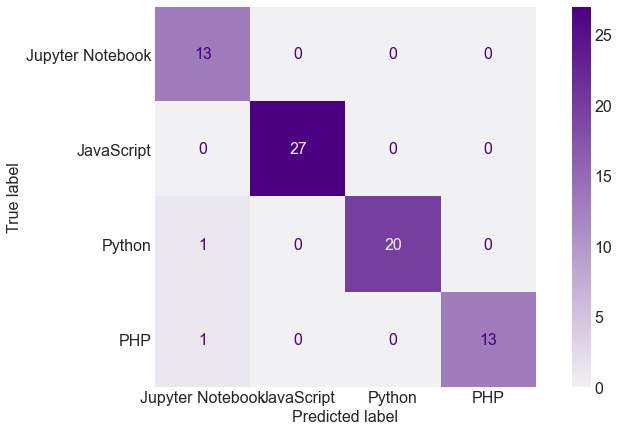


RandomForestClassifier()
~~~~~~~~Validate Scores~~~~~~~~~
                  precision    recall  f1-score   support

      JavaScript       0.57      0.67      0.62         6
Jupyter Notebook       0.92      1.00      0.96        12
             PHP       0.89      0.89      0.89         9
          Python       1.00      0.67      0.80         6

        accuracy                           0.85        33
       macro avg       0.85      0.81      0.82        33
    weighted avg       0.86      0.85      0.85        33



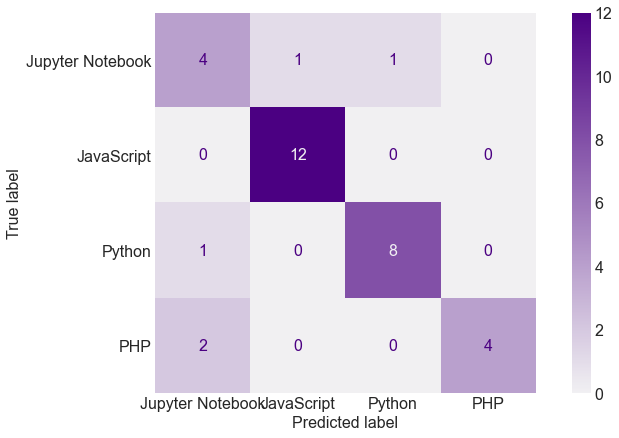


-------------------------------------------------------------------



In [196]:
m.make_models_and_print_metrics(RandomForestClassifier(), 'Random Forest', X_train, y_train, X_validate, y_validate, class_names)

### Key Takeaways 

We constructed a model that used the natural language of the READme file of each repositroy to predict the programming language of that repository. 

 - We used our most frequent language value, "Jupyter Notebook", as our baseline. This gave us a baseline accuracy of 0.36. 
 
 
 - We ran the models Naive Bayes, SVC, Decision Tree, Random Forest, K Nearest Neighbors, and Logistic Regression on: 
     - lemmatized text data,
     - stemmed text data, 
     - cleaned data, and 
     - lemmatized bigrams. 
     
 
 - Our of our models except Random Forest on lemmatized bigrams (`Random_forest_tfidf2`) and K Neartest Neighbors lemmatized bigrams (`KNN_bigrams_tfidf2`) performed with a higher accuracy than baseline on the validate dataset. Thefore, all of our models except the two mentioned are valid. 
 
 
 - Our best performing model on the validate dataset was the Random Forest on lemmatized text `Random_forest_tfidf_lemmatized`, with a score of nearly 0.85 on the validate dataset. 

## Run the Best Model on the Test Dataset

While the model is overfit on the training data, it seems to still do well on the Validate set (85% accuracy). It might be due to the amount of readmes we are pulling from. We can take this model now to our test data to see how it performs.

In [197]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

                   ============== Random Forest Lemmatized ================           
RandomForestClassifier()
~~~~~~~~Test Scores~~~~~~~~~
                  precision    recall  f1-score   support

      JavaScript       0.33      0.40      0.36         5
Jupyter Notebook       0.82      0.90      0.86        10
             PHP       0.73      1.00      0.84         8
          Python       0.00      0.00      0.00         5

        accuracy                           0.68        28
       macro avg       0.47      0.57      0.52        28
    weighted avg       0.56      0.68      0.61        28



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


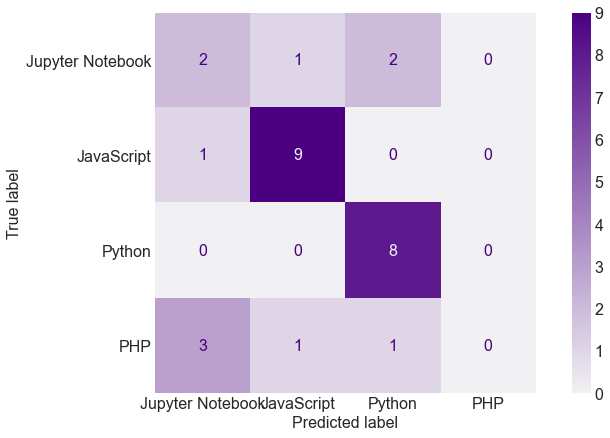


-------------------------------------------------------------------



In [198]:
# The second confusion matrix should be test

m.make_models_and_print_metrics_test_data(RandomForestClassifier(), 'Random Forest Lemmatized', X_train, y_train, X_test, y_test, class_names)

In [199]:
# set palette
sns.set_palette('viridis_r')

# set up second dataframe for scores top 7 
score_df2 = score_df.set_index('model_name').sort_values(by = ['validate_score', 'model_name'], ascending = False).head(7)

# add the test score to the model we tested on (KNN)
score_df2['test_score']= [0.64, 0, 0, 0, 0, 0, 0]

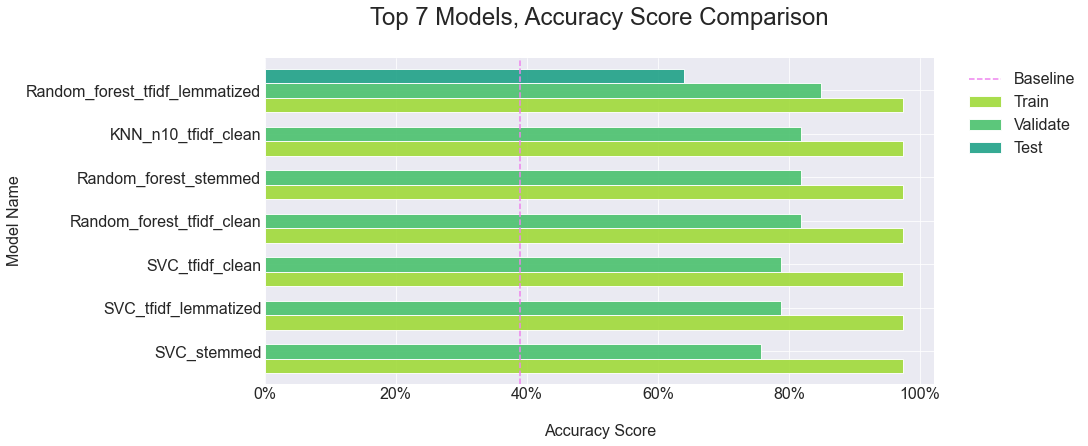

In [200]:
score_df2.sort_values(by= ['test_score', 'validate_score']).plot.barh(alpha = .9, width = 1, ec = 'white', 
                                                                      figsize = (12,6))
# plot baseline
plt.axvline(x = .39, c = 'violet', linestyle = '--')
plt.legend(['Baseline','Train', 'Validate','Test'], bbox_to_anchor = (1.03,1))
plt.ylabel('Model Name')
plt.xlabel('\nAccuracy Score')
# set ticks to percentages
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:.0%}'.format))
plt.title('Top 7 Models, Accuracy Score Comparison\n', fontsize = 24)
plt.show()

### Conclusion 

Our best performing model predicted the test dataset languages with 64% accuracy, outperforming baseline by 28% on the test dataset. 

For future exploration, it may be useful to explore if using a larger dataset would produce a more accurate model. 